In [30]:
from __future__ import print_function    # (at top of module)
import warnings
#warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types

In [31]:
# Read the data from the file
data = pd.read_csv('data_500_entries_youtube.csv')
print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5ygDXis42ncn6kYG14lEVG,Baby Shark,[Pinkfong],77,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,1956582159,Baby Shark Dance | Sing and Dance! | Animal So...
1,spotify:track:7fa9MBXhVfQ8P8Df9OEbD8,Girls Like You (feat. Cardi B),"[Maroon 5, Cardi B]",86,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,1300452389,Maroon 5 - Girls Like You ft. Cardi B
2,spotify:track:6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,[Danny Ocean],83,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,1229501096,Danny Ocean - Me Rehúso (Official Audio)
3,spotify:track:1j6xOGusnyXq3l6IryKF3G,Déjala Que Vuelva (feat. Manuel Turizo),"[Piso 21, Manuel Turizo]",74,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,1216075058,Piso 21 - Déjala Que Vuelva (feat. Manuel Turi...
4,spotify:track:2ijef6ni2amuunRoKTlgww,Sin Pijama,"[Becky G, Natti Natasha]",90,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,1071141995,Becky G Natti Natasha - Sin Pijama (Video Ofic...


In [32]:
if 'song_id' in data.columns:
    data = data.drop_duplicates(subset=['song_id'], keep='first')
else:
    data = data.drop_duplicates(subset=['song_title'], keep='first')
    
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [33]:
data = data[data.popularity > 50]
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [34]:
from project_modules import *

final_data = label_data(data, 90)

Number of popular examples after thresholding :  47
Number of not popular examples after thresholding :  523


In [35]:
# Drop unnecessary columns from original data - also some legacy support for a different data format
if 'song_id' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_video_title','speechiness','instrumentalness','time_signature', 'danceability', 'key','duration','mode', 'liveness', 'acousticness', 'youtube_view_count'], 1, inplace=True)
else:
    final_data.drop(['song_title', 'artist', 'popularity'], 1, inplace=True) 

In [36]:
final_data.head()

,energy,tempo,loudness,valence,is_popular
0,0.840,115.062,-3.651,0.520,0
1,0.541,124.959,-6.825,0.448,0
2,0.804,104.823,-6.327,0.426,0
3,0.788,170.019,-4.323,0.839,0
4,0.745,94.014,-3.695,0.820,0


In [37]:
# COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
#                     "speechiness", "acousticness", "instrumentalness", 
#                     "time_signature", "danceability", "key", 
#                     "duration", "loudness", "valence", "mode"]
COLUMNS_TO_SCALE = ["energy", "tempo","loudness", "valence"]

# Keep data in a temp variable for testing
scaled_data = scale_data_standardize(final_data, COLUMNS_TO_SCALE)

# Plots to see the difference before/after scaling
# plt.subplot(1,2,1)
# plt.plot(data['duration'])
# plt.title("Duration before scaling")

# plt.subplot(1,2,2)
# plt.plot(scaled_data['duration'])
# plt.title("Duration after scaling")
# plt.tight_layout()
# plt.show()

# Copy data back
final_data = scaled_data.copy()

#Just to check that everything is fine
final_data.head()

,energy,tempo,loudness,valence,is_popular
0,1.134405,-0.263119,1.099652,-0.006954,0
1,-0.725307,0.073383,-0.346005,-0.342110,0
2,0.910493,-0.611250,-0.119182,-0.444518,0
3,0.810977,1.605444,0.793577,1.477973,0
4,0.543526,-0.978761,1.079611,1.389529,0


In [38]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 570
Number of entries in label data: 570


In [39]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)
print("Items in training data set : ", str(len(X_train.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in training data set :  285
Items in testing data set:  285


In [45]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.neural_network import MLPClassifier
models = [
          {'title':"Logistic regression", 'model':LogisticRegression(random_state=3)},
          {'title':"Logistic regression balanced weights", 'model':LogisticRegression(class_weight='balanced', random_state=3)},
          {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(random_state=3))},
          {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(class_weight='balanced',random_state=3))},
          {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17)},
          {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17))},
          {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3)},
          {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced')},
          {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3))},
          {'title':"Multilayer Perceptron", 'model':MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3)}
         ]
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC"]

# Train-test split

Logistic regression

Accuracy:  0.956140350877

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       109
           1       0.00      0.00      0.00         5

   micro avg       0.96      0.96      0.96       114
   macro avg       0.48      0.50      0.49       114
weighted avg       0.91      0.96      0.93       114

Confusion matrix: 
[[109   0]
 [  5   0]]


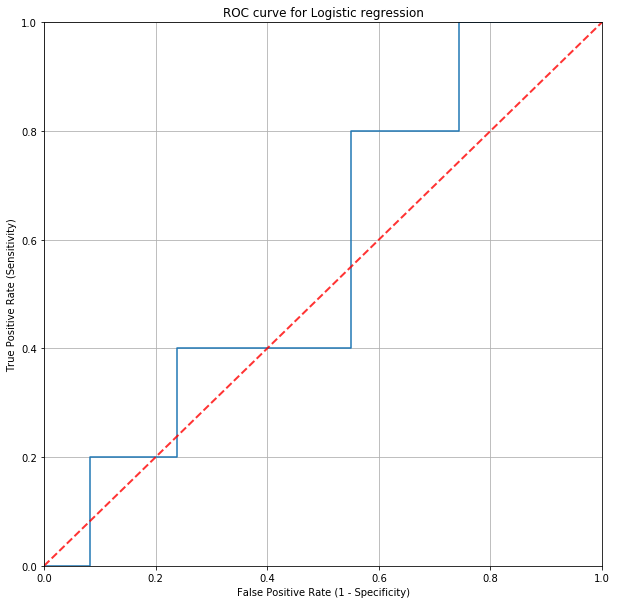

AUC score:  0.566972477064

Logistic regression balanced weights

Accuracy:  0.605263157895

              precision    recall  f1-score   support

           0       0.96      0.61      0.75       109
           1       0.05      0.40      0.08         5

   micro avg       0.61      0.61      0.61       114
   macro avg       0.50      0.51      0.42       114
weighted avg       0.92      0.61      0.72       114

Confusion matrix: 
[[67 42]
 [ 3  2]]


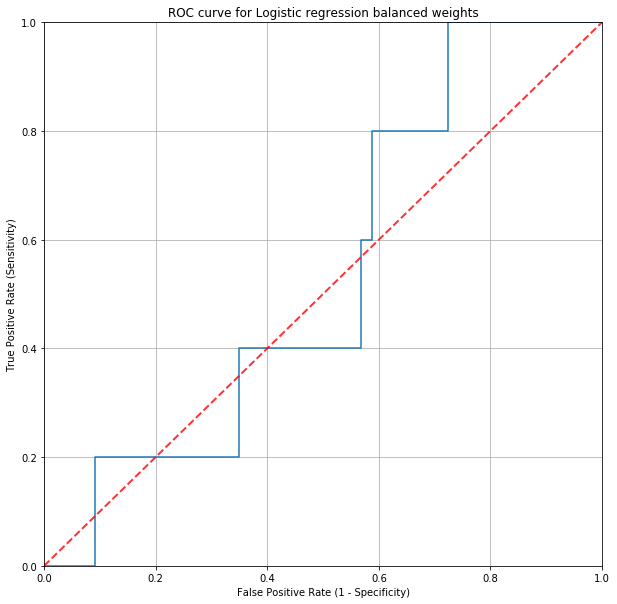

AUC score:  0.535779816514

Oversampling logistic regression

Accuracy:  0.587719298246

              precision    recall  f1-score   support

           0       0.94      0.61      0.74       109
           1       0.02      0.20      0.04         5

   micro avg       0.59      0.59      0.59       114
   macro avg       0.48      0.40      0.39       114
weighted avg       0.90      0.59      0.71       114

Confusion matrix: 
[[66 43]
 [ 4  1]]


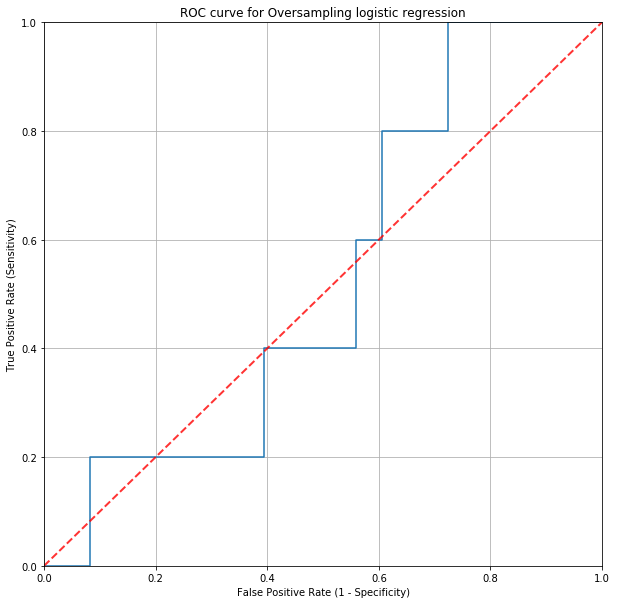

AUC score:  0.526605504587

Oversampling logistic regression balanced weights

Accuracy:  0.587719298246

              precision    recall  f1-score   support

           0       0.94      0.61      0.74       109
           1       0.02      0.20      0.04         5

   micro avg       0.59      0.59      0.59       114
   macro avg       0.48      0.40      0.39       114
weighted avg       0.90      0.59      0.71       114

Confusion matrix: 
[[66 43]
 [ 4  1]]


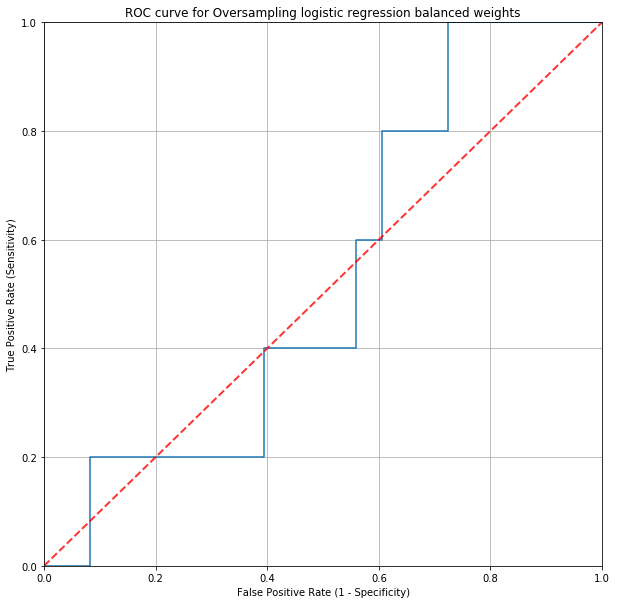

AUC score:  0.526605504587

KNN

Accuracy:  0.956140350877

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       109
           1       0.00      0.00      0.00         5

   micro avg       0.96      0.96      0.96       114
   macro avg       0.48      0.50      0.49       114
weighted avg       0.91      0.96      0.93       114

Confusion matrix: 
[[109   0]
 [  5   0]]


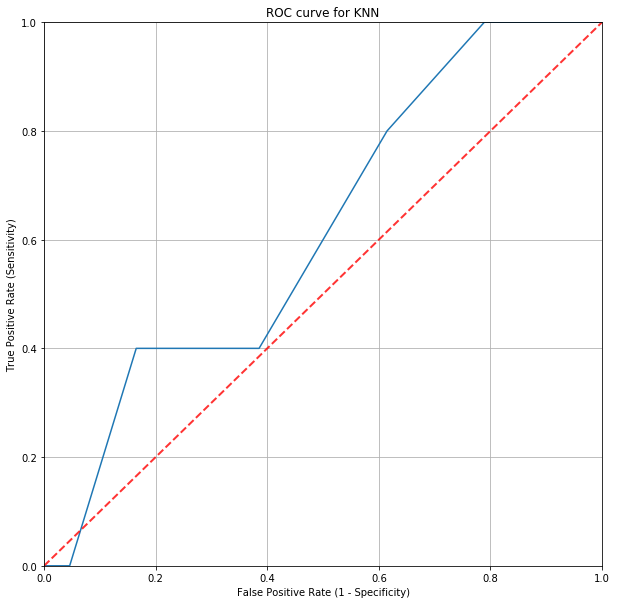

AUC score:  0.617431192661

Oversampling KNN

Accuracy:  0.570175438596

              precision    recall  f1-score   support

           0       0.97      0.57      0.72       109
           1       0.06      0.60      0.11         5

   micro avg       0.57      0.57      0.57       114
   macro avg       0.51      0.58      0.41       114
weighted avg       0.93      0.57      0.69       114

Confusion matrix: 
[[62 47]
 [ 2  3]]


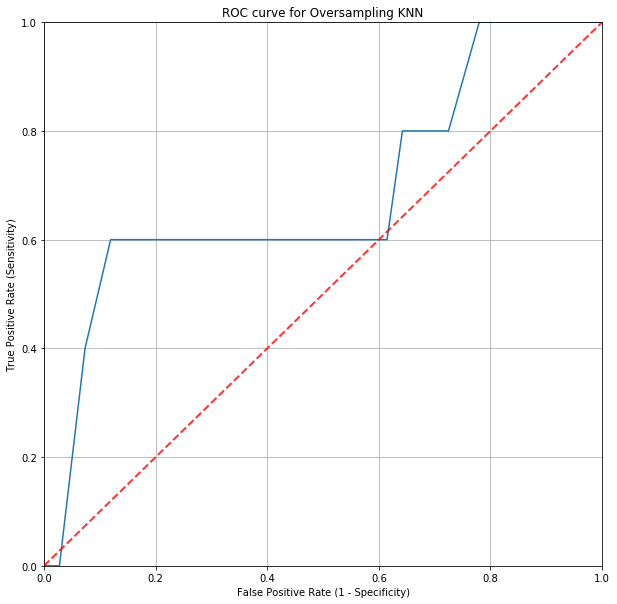

AUC score:  0.684403669725

SVM

Accuracy:  0.956140350877

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       109
           1       0.00      0.00      0.00         5

   micro avg       0.96      0.96      0.96       114
   macro avg       0.48      0.50      0.49       114
weighted avg       0.91      0.96      0.93       114

Confusion matrix: 
[[109   0]
 [  5   0]]


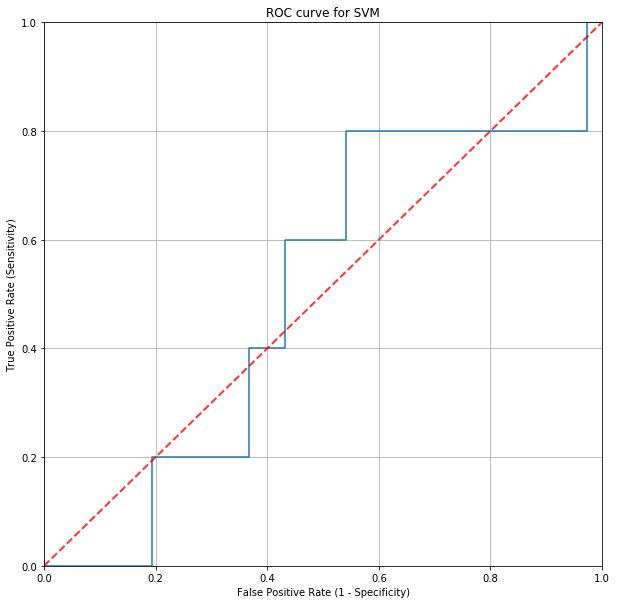

AUC score:  0.499082568807

SVM balanced weights

Accuracy:  0.578947368421

              precision    recall  f1-score   support

           0       0.96      0.59      0.73       109
           1       0.04      0.40      0.08         5

   micro avg       0.58      0.58      0.58       114
   macro avg       0.50      0.49      0.40       114
weighted avg       0.92      0.58      0.70       114

Confusion matrix: 
[[64 45]
 [ 3  2]]


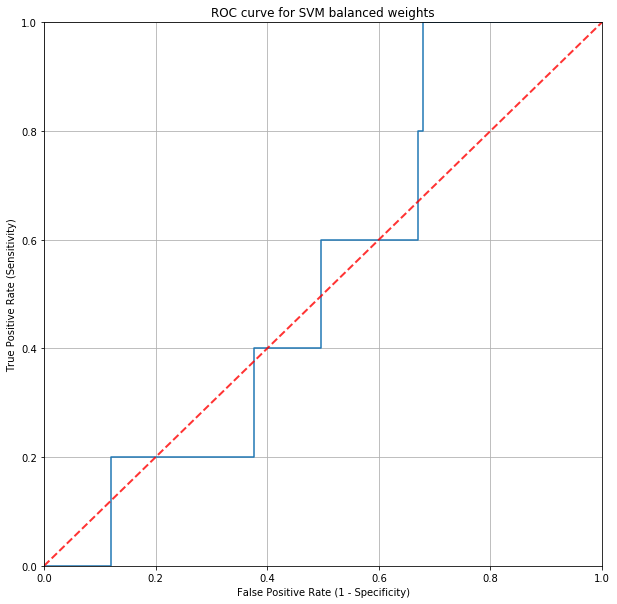

AUC score:  0.532110091743

Oversampling SVM

Accuracy:  0.69298245614

              precision    recall  f1-score   support

           0       0.96      0.71      0.81       109
           1       0.06      0.40      0.10         5

   micro avg       0.69      0.69      0.69       114
   macro avg       0.51      0.55      0.46       114
weighted avg       0.92      0.69      0.78       114

Confusion matrix: 
[[77 32]
 [ 3  2]]


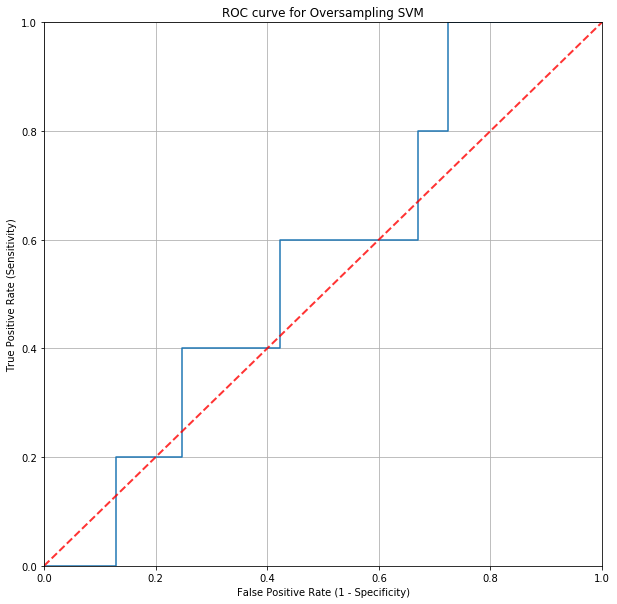

AUC score:  0.561467889908

Multilayer Perceptron

Accuracy:  0.956140350877

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       109
           1       0.00      0.00      0.00         5

   micro avg       0.96      0.96      0.96       114
   macro avg       0.48      0.50      0.49       114
weighted avg       0.91      0.96      0.93       114

Confusion matrix: 
[[109   0]
 [  5   0]]


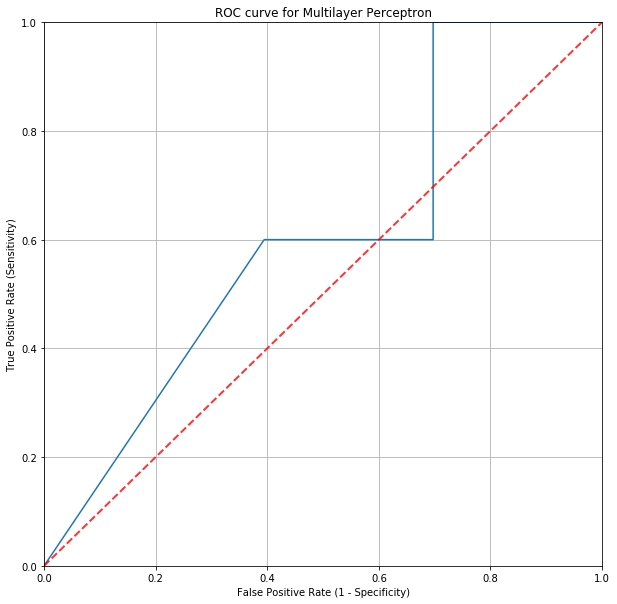

AUC score:  0.602752293578



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC
0,Logistic regression,0.956140,1.000000,0.0,0.000000,0.934702,0.566972
1,Logistic regression balanced weights,0.605263,0.614679,0.4,0.045455,0.719350,0.535780
2,Oversampling logistic regression,0.587719,0.605505,0.2,0.022727,0.706877,0.526606
3,Oversampling logistic regression balanced weights,0.587719,0.605505,0.2,0.022727,0.706877,0.526606
4,KNN,0.956140,1.000000,0.0,0.000000,0.934702,0.617431
5,Oversampling KNN,0.570175,0.568807,0.6,0.060000,0.690111,0.684404
6,SVM,0.956140,1.000000,0.0,0.000000,0.934702,0.499083
7,SVM balanced weights,0.578947,0.587156,0.4,0.042553,0.698749,0.532110
8,Oversampling SVM,0.692982,0.706422,0.4,0.058824,0.783576,0.561468
9,Multilayer Perceptron,0.956140,1.000000,0.0,0.000000,0.934702,0.602752


In [46]:
stats = []
for item in models:
    # Train-test split
    print(item['title'])
    
    # Train the model
    item['model'].fit(X_train, y_train)

    # Classifiy test examples
    predictions = item['model'].predict(X_test)
    print()

    # Print the accuracy score of the model
    print("Accuracy: ", accuracy_score(y_test, predictions))

    print()

    # Print the classification report of the model
    print(classification_report(y_test, predictions))

    # Print the confusion matrix
    
    print("Confusion matrix: ")
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    
    # ROC curve
    y_pred_prob = item['model'].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.plot([0,0],[1,1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    plt.title('ROC curve for ' + item['title'])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()

    # AUC score
    print("AUC score: ", roc_auc_score(y_test, y_pred_prob))
    
    print()
    
    accuracy = accuracy_score(y_test, predictions)
    specificity = float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    auc = roc_auc_score(y_test, y_pred_prob)
    newRow = [item['title'],accuracy, specificity, recall, precision, f1, auc]
    stats.append(newRow)
stats_df = pd.DataFrame(stats, columns = stats_columns)
stats_df

# 10 Fold Cross Validation

Logistic regression


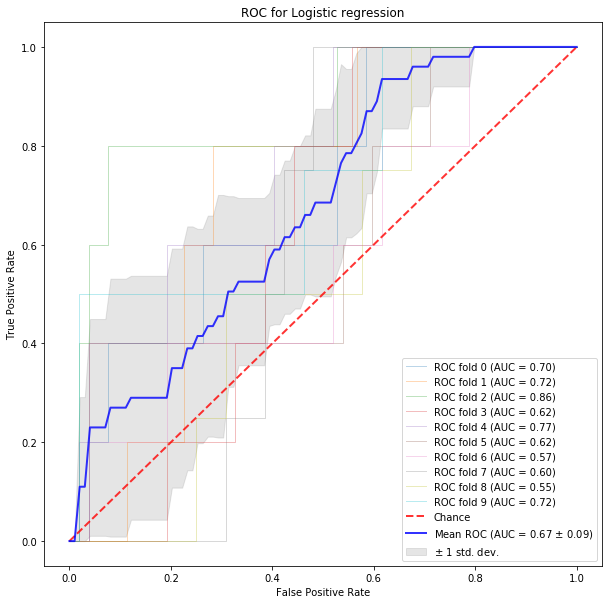

Accuracy mean:  0.917621640308

Logistic regression balanced weights


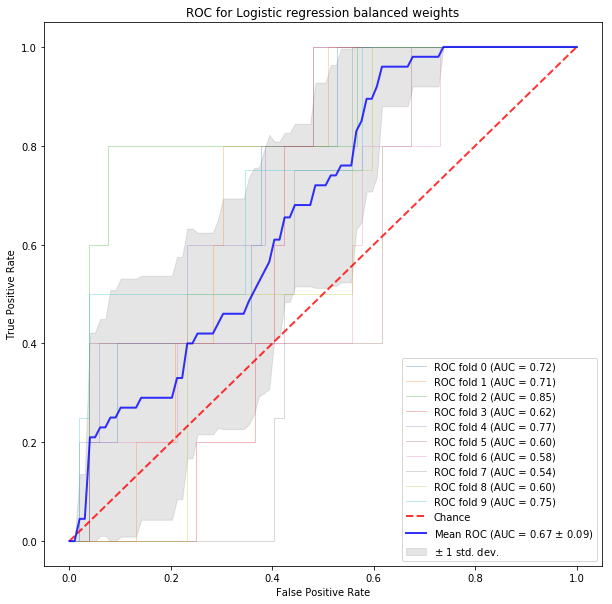

Accuracy mean:  0.606733428399

Oversampling logistic regression


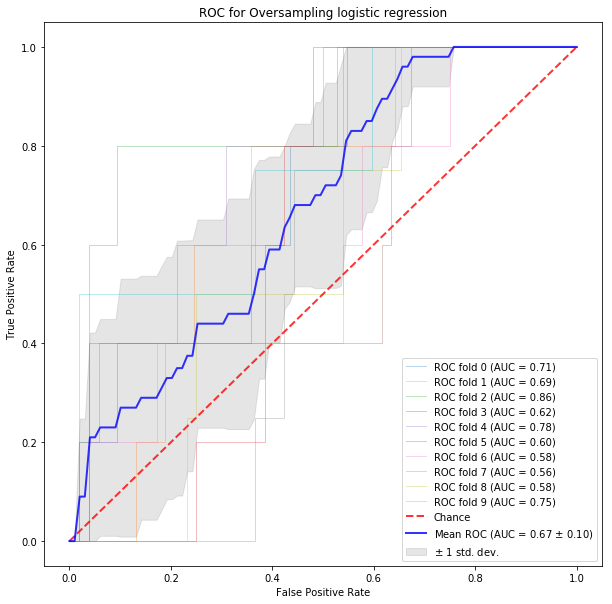

Accuracy mean:  0.617354809437

Oversampling logistic regression balanced weights


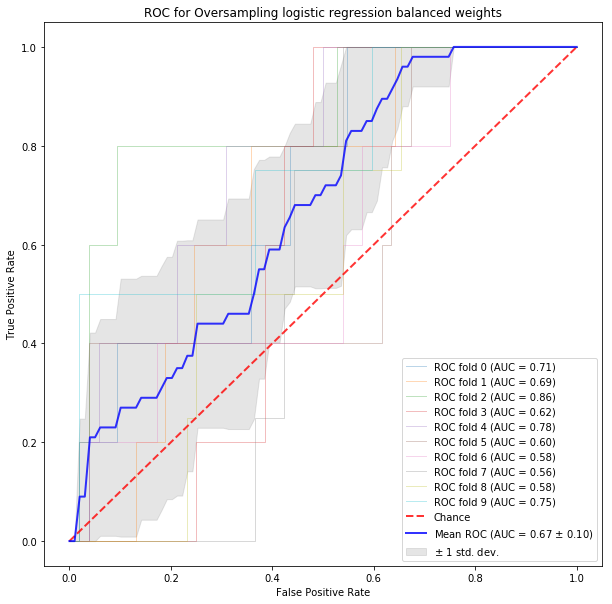

Accuracy mean:  0.617354809437

KNN


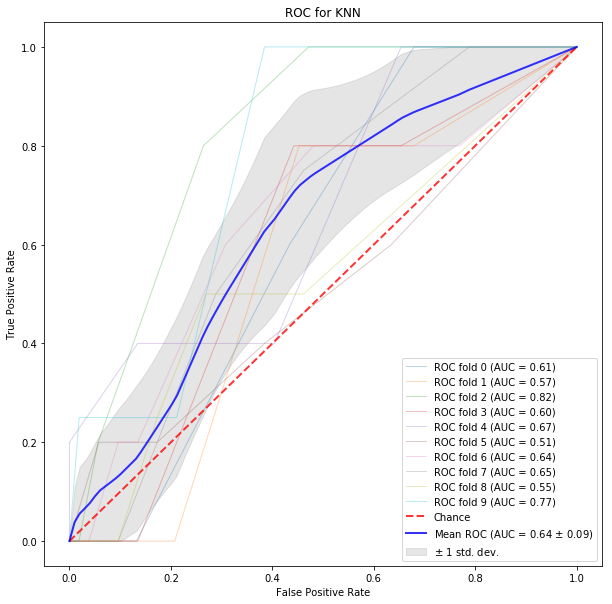

Accuracy mean:  0.917621640308

Oversampling KNN


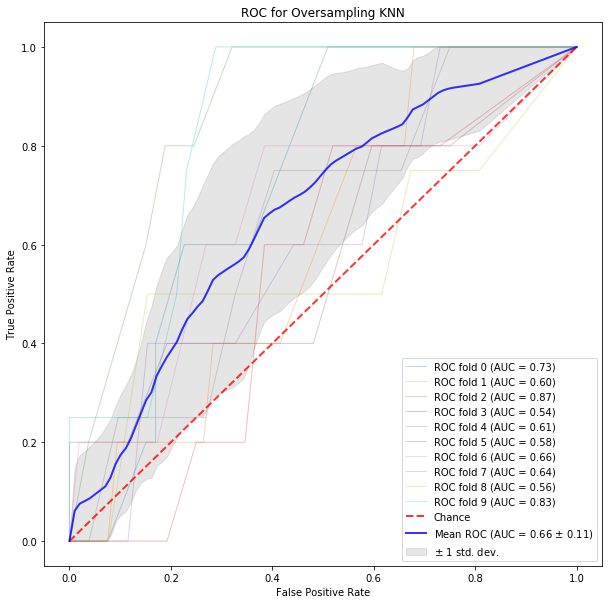

Accuracy mean:  0.606982974678

SVM


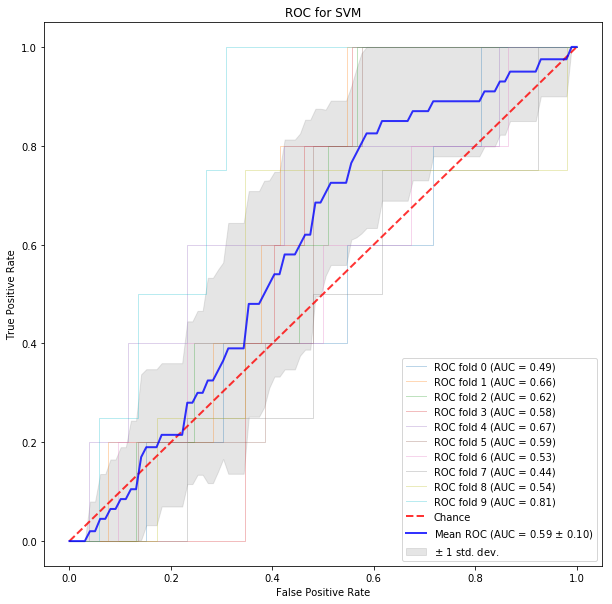

Accuracy mean:  0.917621640308

SVM balanced weights


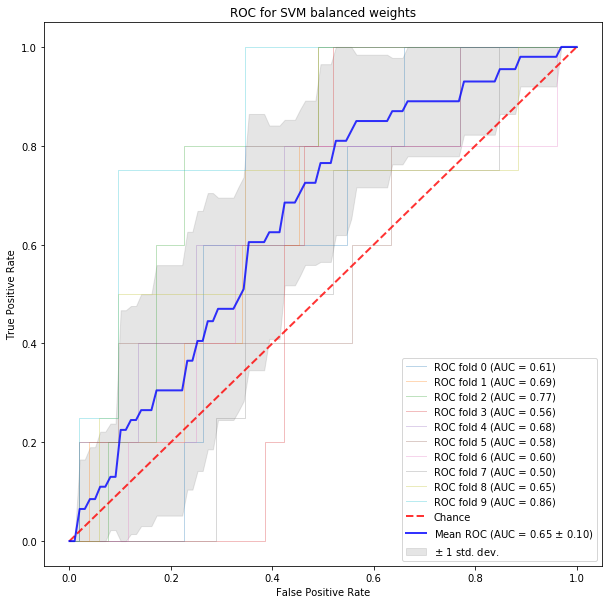

Accuracy mean:  0.592754515599

Oversampling SVM


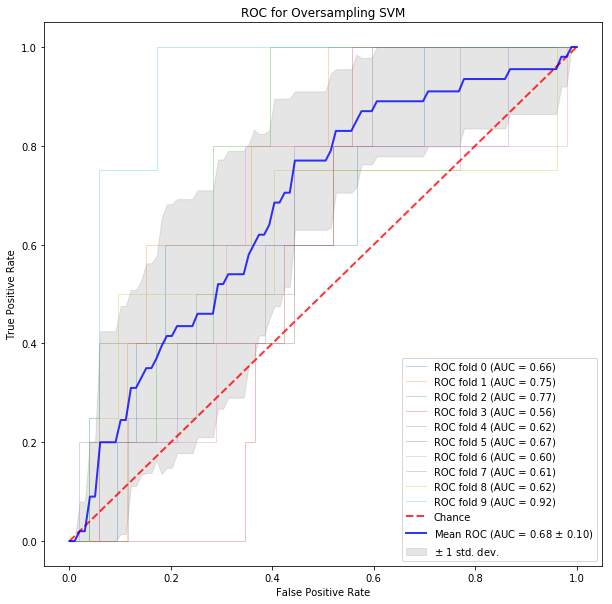

Accuracy mean:  0.669933454325

Multilayer Perceptron


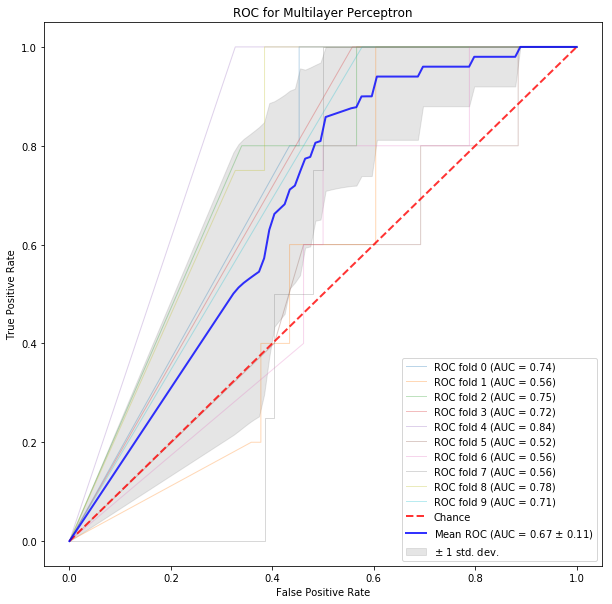

Accuracy mean:  0.917621640308



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC
0,Logistic regression,0.917622,1.000000,0.000,0.000000,0.878217,0.672323
1,Logistic regression balanced weights,0.606733,0.605878,0.605,0.121400,0.692717,0.674596
2,Oversampling logistic regression,0.617355,0.619267,0.585,0.121495,0.700848,0.672475
3,Oversampling logistic regression balanced weights,0.617355,0.619267,0.585,0.121495,0.700848,0.672475
4,KNN,0.917622,1.000000,0.000,0.000000,0.878217,0.639555
5,Oversampling KNN,0.606983,0.602032,0.665,0.132013,0.692116,0.660866
6,SVM,0.917622,1.000000,0.000,0.000000,0.878217,0.591717
7,SVM balanced weights,0.592755,0.590675,0.625,0.116819,0.680730,0.651111
8,Oversampling SVM,0.669933,0.676633,0.600,0.139567,0.741153,0.677071
9,Multilayer Perceptron,0.917622,1.000000,0.000,0.000000,0.878217,0.673071


In [47]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
X = np.array(X)
y = np.array(y)
cv = StratifiedKFold(n_splits=10)
cv_stats = []
for item in models:
    # Run classifier with cross-validation and plot ROC curves
    print(item['title'])
    classifier = item['model']
    tprs = []
    aucs = []
    accs = []
    specificities = []
    recalls = []
    precisions = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        predicts = classifier.predict(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        conf_matrix = confusion_matrix(y[test], predicts)
        roc_auc = auc(fpr, tpr)
        
        aucs.append(roc_auc)
        accs.append(accuracy_score(y[test], predicts))
        specificities.append(float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1]))
        recalls.append(recall_score(y[test], predicts))
        precisions.append(precision_score(y[test], predicts))
        f1s.append(f1_score(y[test], predicts, average='weighted'))
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + item['title'])
    plt.legend(loc="lower right")
    plt.show()

    print("Accuracy mean: ",np.mean(accs))
    print()
    newRow = [item['title'],np.mean(accs), np.mean(specificities), np.mean(recalls), np.mean(precisions), np.mean(f1s), mean_auc]
    cv_stats.append(newRow)
stats_df = pd.DataFrame(cv_stats, columns = stats_columns)
stats_df

# 10CV - Done right?

Logistic regression


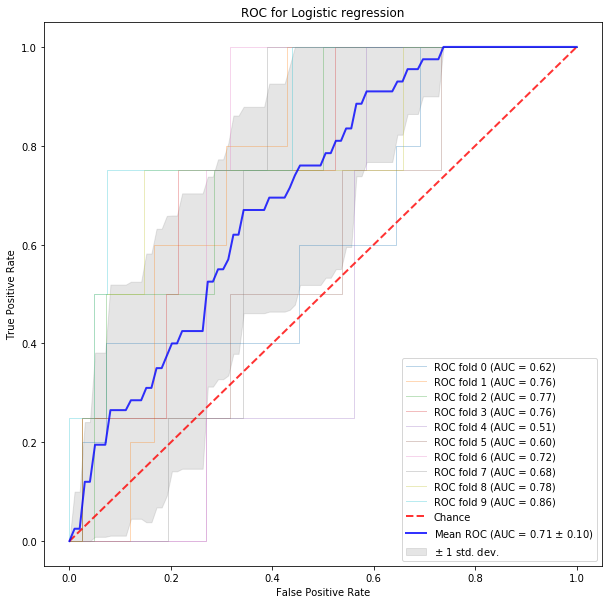

Accuracy mean:  0.907998766574

Logistic regression balanced weights


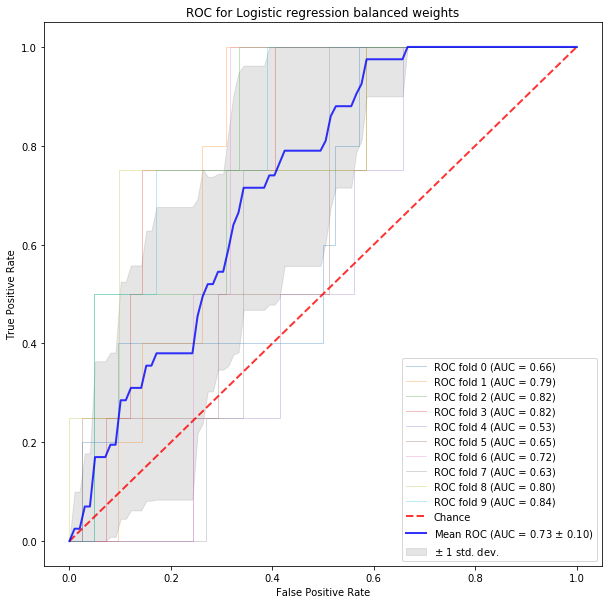

Accuracy mean:  0.646699558022

Oversampling logistic regression


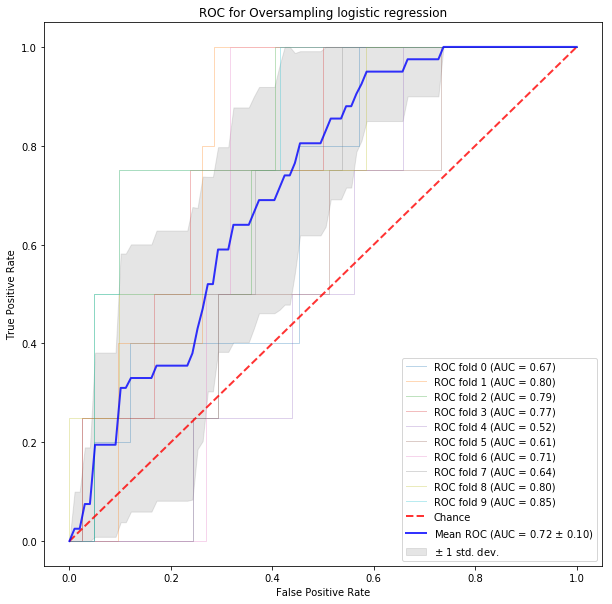

Accuracy mean:  0.655399321616

Oversampling logistic regression balanced weights


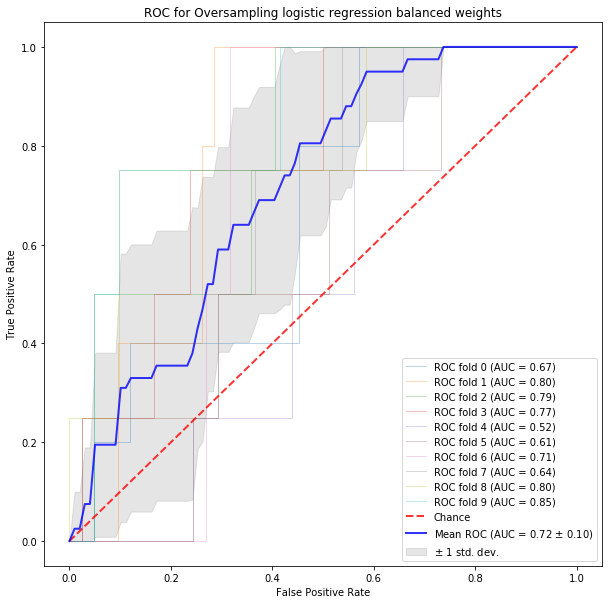

Accuracy mean:  0.655399321616

KNN


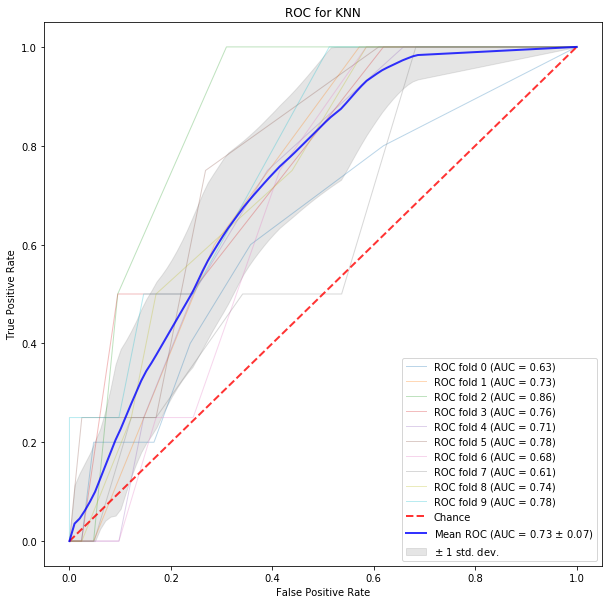

Accuracy mean:  0.907998766574

Oversampling KNN


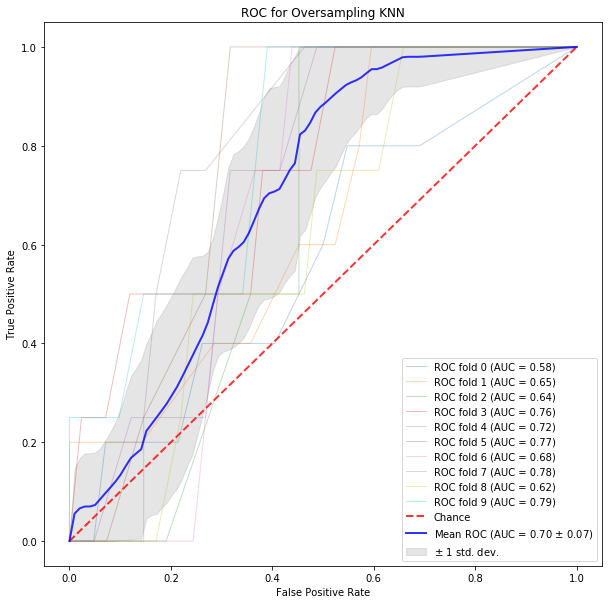

Accuracy mean:  0.612282865659

SVM


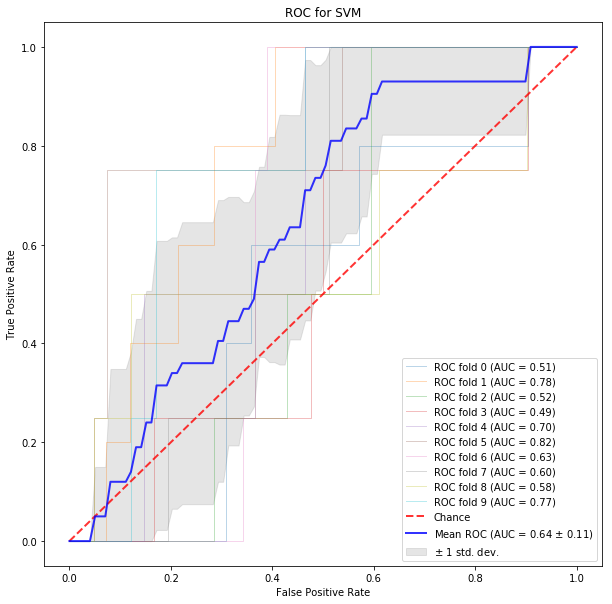

Accuracy mean:  0.907998766574

SVM balanced weights


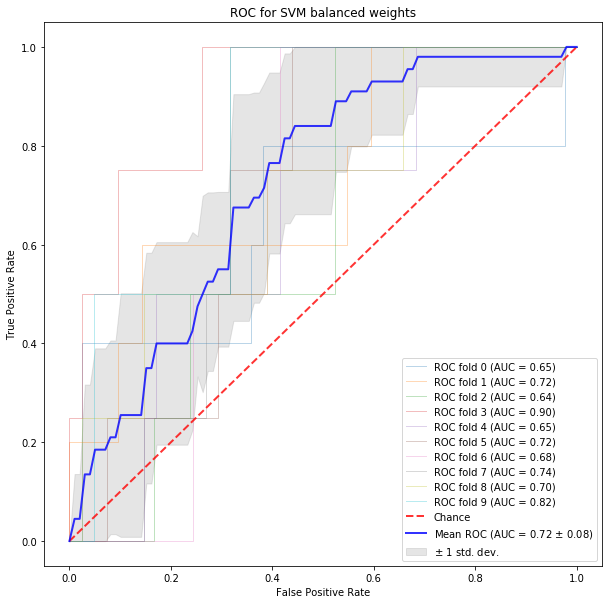

Accuracy mean:  0.642826600884

Oversampling SVM


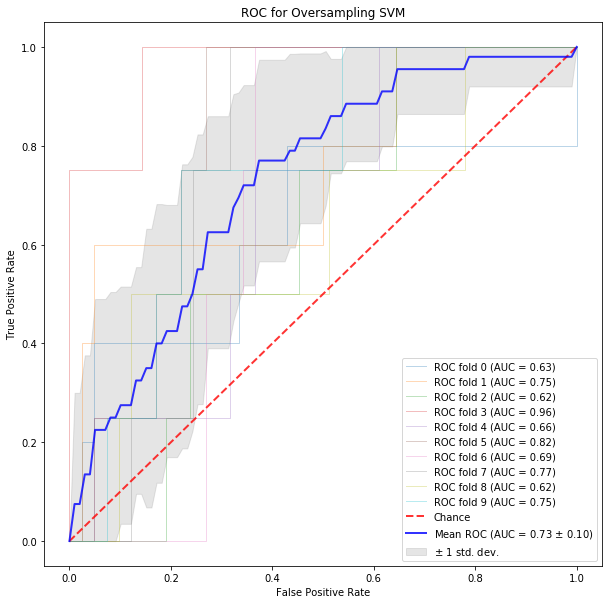

Accuracy mean:  0.69714050776

Multilayer Perceptron


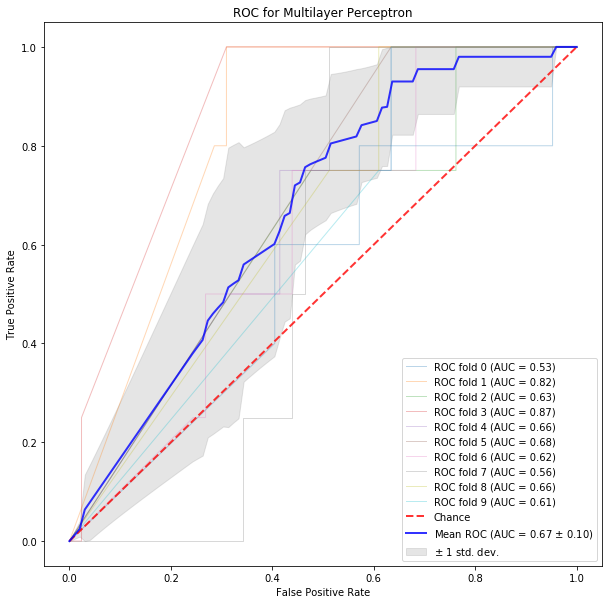

Accuracy mean:  0.905824853531



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC,Generalized AUC
0,Logistic regression,0.907999,1.000000,0.000,0.000000,0.864231,0.706768,0.533945
1,Logistic regression balanced weights,0.646700,0.647271,0.640,0.155180,0.719628,0.725000,0.504587
2,Oversampling logistic regression,0.655399,0.659292,0.615,0.156729,0.726303,0.716162,0.517431
3,Oversampling logistic regression balanced weights,0.655399,0.659292,0.615,0.156729,0.726303,0.716162,0.517431
4,KNN,0.907999,1.000000,0.000,0.000000,0.864231,0.727529,0.542202
5,Oversampling KNN,0.612283,0.596806,0.775,0.160435,0.691310,0.697478,0.578899
6,SVM,0.907999,1.000000,0.000,0.000000,0.864231,0.640000,0.482569
7,SVM balanced weights,0.642827,0.650058,0.575,0.134706,0.715984,0.720303,0.447706
8,Oversampling SVM,0.697141,0.700174,0.675,0.186054,0.758486,0.728434,0.500917
9,Multilayer Perceptron,0.905825,0.997619,0.000,0.000000,0.863134,0.665074,0.502752


In [49]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC", "Generalized AUC"]
X = np.array(X)
y = np.array(y)
cv = StratifiedKFold(n_splits=10)
cv_stats = []
X_fs, X_test, y_fs, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
for item in models:
    # Run classifier with cross-validation and plot ROC curves
    print(item['title'])
    classifier = item['model']
    tprs = []
    aucs = []
    accs = []
    specificities = []
    recalls = []
    precisions = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X_fs, y_fs):
        probas_ = classifier.fit(X_fs[train], y_fs[train]).predict_proba(X_fs[test])
        predicts = classifier.predict(X_fs[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_fs[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        conf_matrix = confusion_matrix(y_fs[test], predicts)
        roc_auc = auc(fpr, tpr)
        
        aucs.append(roc_auc)
        accs.append(accuracy_score(y_fs[test], predicts))
        specificities.append(float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1]))
        recalls.append(recall_score(y_fs[test], predicts))
        precisions.append(precision_score(y_fs[test], predicts))
        f1s.append(f1_score(y_fs[test], predicts, average='weighted'))
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + item['title'])
    plt.legend(loc="lower right")
    plt.show()

    print("Accuracy mean: ",np.mean(accs))
    print()
    #item['model'].fit(X_fs, y_fs)
    y_pred_prob = item['model'].predict_proba(X_test)[:,1]
    test_after_auc = roc_auc_score(y_test, y_pred_prob)
    newRow = [item['title'],np.mean(accs), np.mean(specificities), np.mean(recalls), np.mean(precisions), np.mean(f1s), mean_auc, test_after_auc]
    cv_stats.append(newRow)
stats_df = pd.DataFrame(cv_stats, columns = stats_columns)
stats_df